In [5]:
%matplotlib inline

%load_ext autoreload
%autoreload

import math

import numpy as np
import statsmodels.api as sm
import scipy.spatial.distance as ssd
import scipy.stats as ss
import matplotlib.pyplot as plt
import time
import random
from scipy.stats import norm

import csv

# Prepocessing Data

In [33]:
# d_cell_fit = np.load('pl_cell_activity.npy')
# d_loc_fit = np.load('location.npy').transpose()

# # delete datas when the mouse is not moving
# cell_num, time_num = np.shape(d_cell_fit)
# cell_fit = [[d_cell_fit[i][0]] for i in range(cell_num)]
# loc_fit = [d_loc_fit[0]]

# for t in range(1, time_num):
#     if d_loc_fit[t] != d_loc_fit[t-1]:
#         for i in range(cell_num):
#             cell_fit[i].append(d_cell_fit[i][t])
#         loc_fit.append(d_loc_fit[t])

# cell_data = np.array(cell_fit)
# loc_data = np.array(loc_fit)
    

# Bayesian Decoder

In [34]:
# dt = 1 / 60
# track_len = 400
# track_sample_len = 2
# track_Bins = int(track_len / track_sample_len)
# cell_num = 50

### Fitting

In [35]:
def fit(cell_train, loc_train, track_len, track_sample_len, track_Bins, cell_num):
    '''
    A function to fit the tuning curve of each place cell

    Input:
    -----
    cell_train: array, place cell activity to fit with [cell, firing rate at each sampling time]
    loc_train: array, locations to fit with [location at each time]

    Output:
    -------
    print total time of fitting
    '''
    tuning = np.zeros((cell_num, track_Bins))  # fit parameter indicating tuning curv
    t0 = time.time()
    loc_range = np.linspace(0, track_len, track_Bins)
    loc_train = np.floor(loc_train / track_sample_len) * track_sample_len
    loc_range_re = np.array([loc_range, loc_range ** 2]).transpose()
    loc_train_re = np.array([loc_train, loc_train ** 2]).transpose()

    # fit tuning curve for each cell
    for cell_id in range(cell_num):
        Y = sm.add_constant(loc_train_re)
        poiss_model = sm.GLM(cell_train[cell_id], Y, family=sm.families.Poisson())
        glm_res = poiss_model.fit()
        tuning_cur = glm_res.predict(sm.add_constant(loc_range_re))
        tuning[cell_id] = tuning_cur
    print('fit_time: ', time.time() - t0)

    # plot example: plot decoding performance for an example trial
    xs = np.zeros((cell_num, track_Bins))
    ys = np.zeros((cell_num, track_Bins))
    zs = np.zeros((cell_num, track_Bins))
    for i in range(cell_num):
        zs[i, :] = tuning[i].copy()
        xs[i, :] = loc_range.copy()
        ys[i, :] = [i + 1 for n in range(track_Bins)]
    xs = xs.flatten()
    ys = ys.flatten()
    zs = zs.flatten()
    zs = zs / np.max(zs)
    plt.scatter(xs, ys, c=zs)
    plt.colorbar()
    plt.show()

    # recording possibility at one position, used in test_loc()
    counts = np.zeros(track_Bins)
    for i in range(np.shape(loc_train)[0]):
        which = int(loc_train[i] / track_sample_len)
        counts[which] += 1
    counts = counts / np.sum(counts)
    loc_possi = counts
    
    # recording standard deviation, then calculate possibility of going from one position to another, used in test_loc_transition()
    time_Bins = np.shape(loc_train)[0]
    dx = np.zeros([time_Bins-1, 1])
    for i in range(track_Bins - 1):
        dx[i] = loc_train[i+1] - loc_train[i]
    std = np.sqrt(np.mean(dx**2))
    
    locs = np.linspace(0, track_len, track_Bins)
    dists = np.zeros([track_Bins, track_Bins])
    for i in range(track_Bins):
        for j in range(track_Bins):
            dists[i][j] = (j-i)*2
    loc_prob = norm.pdf(dists, 0, std)
    for i in range(track_Bins):
        loc_prob[i,i] = 0
        
    return tuning, loc_possi, loc_prob

fit_time:  72.53555393218994


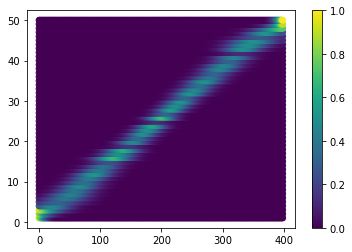

In [36]:
# tuning, loc_possi, loc_prob = fit(cell_data[:, :20000], loc_data[:20000], track_len, track_sample_len, track_Bins, cell_num)

### Decoding positions

In [37]:
class BayesianDecoder:
    def __init__(self, dt, track_len, track_sample_len, track_Bins, cell_num, tuning, loc_possi=None, loc_prob=None):
        self.dt = dt
        self.track_len = track_len
        self.track_sample_len = track_sample_len
        self.track_Bins = track_Bins
        self.cell_num = cell_num
        self.tuning = tuning
        if loc_possi is not None:
            self.loc_possi = loc_possi
        if loc_prob is not None:
            self.loc_prob = loc_prob

    def decoder(self, roll_time):
        predict = np.zeros(np.shape(self.test_loc_data))
        predict_acc = np.zeros(np.shape(self.test_loc_data))
        return predict, predict_acc    

    def test(self, test_cell_data, test_loc_data=None):
        '''
        A function to show fitting performance for several test trials

        Input:
        -----
        test: array, position train for test trials
        predict: array, predicted position train
        predict_acc: array, the predict possibility at actual position for each time bin

        Output:
        -------
        Plot two plots, one for Decoding Error (actual position minus predicted position),
        another for Decoding Accuracy (average of predict_acc on each position)
        '''
        self.test_cell_data = test_cell_data
        self.test_loc_data = test_loc_data
        predict, predict_acc = self.decoder(0, test=True)
        shuffle = np.zeros(np.shape(predict))
        shuffle_acc = np.zeros(np.shape(predict_acc))
        t = 0
        while t < 100:
            add1, add2 = self.decoder(np.random.randint(0, 1200), test=True)
            shuffle += add1
            shuffle_acc += add2
            t += 1
        shuffle /= t
        shuffle_acc /= t

        num = np.shape(self.test_loc_data)[0]
        x = np.array([i for i in range(num)])
        x2 = np.linspace(0, self.track_len, self.track_Bins)
        plt.plot(x, self.test_loc_data, color='blue', label='actual')
        plt.plot(x, predict, color='orange', label='predict')
        plt.plot(x, shuffle, color='grey', label='shuffle')
        plt.legend()
        plt.ylabel('Position(cm)')
        plt.show()

        # Decoding error
        plt.subplot(211)
        plt.plot(x, self.test_loc_data - predict, label='predict')
        plt.plot(x, shuffle - predict, color='grey', label='shuffle')
        plt.legend()
        plt.ylabel('Decoding Error \n Actual - Predicted (cm)')
        plt.title('Decoding Performace by Space')
        plt.subplot(212)
        # reform predict accuracy data
        test = np.floor(self.test_loc_data / self.track_sample_len) * self.track_sample_len
        acc = np.zeros(self.track_Bins)
        counts = np.zeros(self.track_Bins)
        for i in range(np.shape(test)[0]):
            loc = int(test[i] / self.track_sample_len)
            acc[loc] += predict_acc[i]
            counts[loc] += 1
        for k in range(self.track_Bins):
            if counts[k] != 0:
                acc[k] = acc[k] / counts[k]
        s_acc = np.zeros(self.track_Bins)
        counts = np.zeros(self.track_Bins)
        for i in range(np.shape(test)[0]):
            loc = int(test[i] / self.track_sample_len)
            s_acc[loc] += shuffle_acc[i]
            counts[loc] += 1
        for k in range(self.track_Bins):
            if counts[k] != 0:
                s_acc[k] = s_acc[k] / counts[k]
        plt.plot(x2, acc, color='orange',label='predict')
        plt.plot(x2, s_acc, color='grey', label='shuffle')
        plt.legend()
        plt.ylabel('Decoding Accuracy')
        plt.xlabel('Position in Virtual Space (cm)')
        plt.show()
    
    def predict(self, cell_trains, pos, pos_test=None):
        self.test_cell_data = cell_trains
        self.test_loc_data = pos_test
        self.pos = pos
        predict = self.decoder(0)[0]
        return predict
            
        

### Memoryless Decoder
Depend on the formula showed below

![Memoryless](./memoryless.png)

In [38]:
class MemorylessDecoder(BayesianDecoder):
    def decoder(self, cell_data, roll_time=0, test=None):
        '''
        A function to predict positions basing on experimental cell activity data and fitting parameters in self.fit()
        Using a memoryless probability-based decoding algorithm from Pfeiffer 2013

        Input:
        ------
        cell_test: array, cell activity data [cell, firing rate at each sampling time]
        loc_test: array, position data to be tested
        '''
        time_Bins = np.shape(cell_data)[1]
        loc_predict = np.zeros(time_Bins)
        if test:
            loc_predict_acc = np.zeros(time_Bins)
        else:
            loc_predict_acc = None
        for time in range(time_Bins):
            probs = np.zeros(self.track_Bins)
            spike = np.roll(np.round(cell_data[:, time] * self.dt), roll_time)
            for loc in range(self.track_Bins):
                probs[loc] = np.prod(self.tuning[:, loc]** spike) * np.exp(- np.sum(self.tuning[:, loc]) * self.dt)
            if np.sum(probs) != 0:
                probs = probs / np.sum(probs)
            loc_predict[time] = np.argmax(probs) * self.track_sample_len
            if test:
                loc_predict_acc[time] = probs[math.floor(self.test_loc_data[time] / self.track_sample_len)]
        return loc_predict, loc_predict_acc

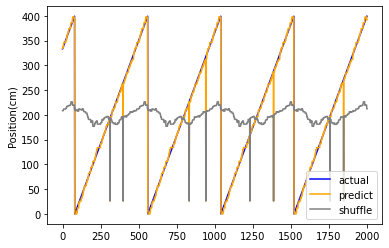

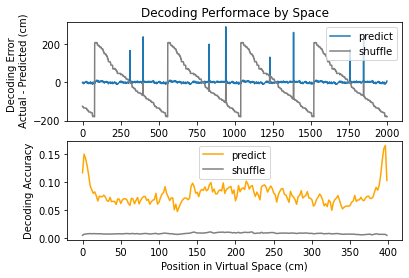

In [39]:
# MD = MemorylessDecoder(dt, track_len, track_sample_len, track_Bins, cell_num, tuning)
# MD.test(cell_data[:, -2000:], loc_data[-2000:])

### Position-based Decoder
Depend on the formula showed below

![](.\position-based.png)

In [40]:
class Position_basedDecoder(BayesianDecoder):
    def decoder(self, roll_time, test=None):
        '''
        A function to predict positions basing on experimental cell activity data and fitting parameters in self.fit()
        Using a position-related probability-based decoding algorithm from Tingley and Peyrache 2019

        Input:
        ------
        cell_test: array, cell activity data [cell, time]
        loc_test: array, position data to be tested
        '''
        time_Bins = np.shape(self.test_cell_data)[1]
        loc_predict = np.zeros(time_Bins)
        if not test:
            loc_predict_acc = None
        else:
            loc_predict_acc = np.zeros(time_Bins)
        for time in range(time_Bins):
            probs = np.zeros(self.track_Bins)
            spike = np.roll(np.round(self.test_cell_data[:, time] * self.dt), roll_time)
            for loc in range(self.track_Bins):
                probs[loc] = self.loc_possi[loc] * np.prod(self.tuning[:, loc] ** spike) * np.exp(-np.sum(self.tuning[:, loc]) * self.dt)
            if np.sum(probs) != 0:
                probs = probs / np.sum(probs)
            loc_predict[time] = np.argmax(probs)
            if test is not None:
                loc_predict_acc[time] = probs[int(math.floor(self.test_loc_data[time] / self.track_sample_len))]
        loc_predict = np.round(loc_predict * self.track_len / self.track_Bins, 2)
        return loc_predict, loc_predict_acc

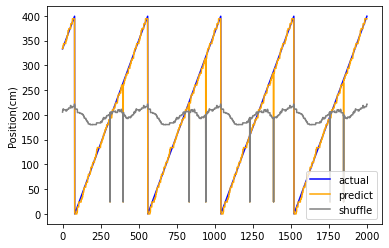

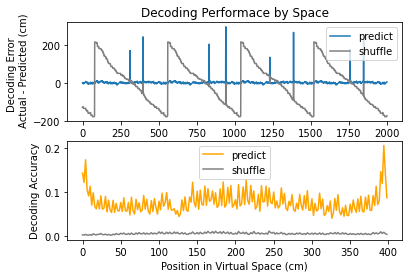

In [41]:
# # show the performance of Position-based Decoder
# PD = Position_basedDecoder(dt, track_len, track_sample_len, track_Bins, cell_num, tuning, loc_possi=loc_possi)
# PD.test(cell_data[:, -2000:], loc_data[-2000:])

### Position-transient Decoder

In [44]:
class Loc_trainsitionDecoder(BayesianDecoder):
    def decoder(self, roll_time, test=None):
        '''
        A function to predict positions basing on experimental cell activity data and fitting parameters in self.fit()
        Using a position-transient probability-based decoding algorithm from Kording's lab

        Input:
        ------
        cell_test: array, cell activity data [cell, time]
        loc_test: array, position data to be tested
        '''        
        time_Bins = np.shape(self.test_cell_data)[1]
        if test is not None:
            pos = int(np.roll(self.test_loc_data, roll_time)[0] / self.track_sample_len)
        else:
            pos = int(math.ceil(self.pos))
        loc_predict = np.zeros(time_Bins)
        if not test:
            loc_predict_acc = None
        else:
            loc_predict_acc = np.zeros(time_Bins)
        for time in range(time_Bins):
            probs = np.zeros(self.track_Bins)
            spike = np.roll(np.round(self.test_cell_data[:, time] * self.dt), roll_time)
            for loc in range(self.track_Bins):
                probs[loc] = self.loc_prob[pos, loc] * np.prod(self.tuning[:, loc] ** spike) * np.exp(-np.sum(self.tuning[:, loc]) * self.dt)
            if np.sum(probs) != 0:
                probs = probs / np.sum(probs)
            pos = np.argmax(probs)
            loc_predict[time] = pos
            if test is not None:
                loc_predict_acc[time] = probs[math.floor(self.test_loc_data[time] / self.track_sample_len)]
        loc_predict = np.round(loc_predict * self.track_len / self.track_Bins, 2)
        return loc_predict, loc_predict_acc

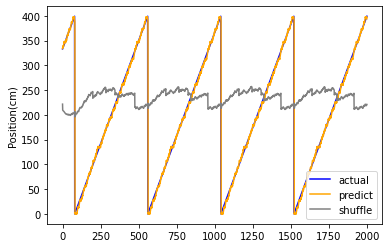

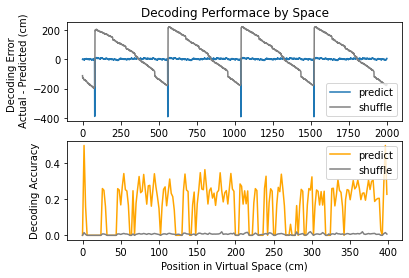

In [45]:
# # show the performance of Position-transient Decoder
# LD = Loc_trainsitionDecoder(dt, track_len, track_sample_len, track_Bins, cell_num, tuning, loc_prob=loc_prob)
# LD.test(cell_data[:, -2000:], loc_data[-2000:])

### Test on designed events

In [46]:
# # get place cell parameters
# cell_info = np.load('cell_info.npy')
# pc_dic = dict()
# total = np.shape(cell_info)[0]
# for i in range(total):
#     if cell_info[i][0] == 1:
#         pc_dic[cell_info[i][3]] = cell_info[i][2]
# # 需要按照center的位置排序
# pc_list = np.zeros((cell_num, 2))
# sort = sorted(pc_dic)
# for i in range(cell_num):
#     pc_list[i][0] = sort[i]
#     pc_list[i][1] = pc_dic[sort[i]]
# print(pc_list)

[[  4.          21.12522961]
 [ 12.          20.71903834]
 [ 20.          40.24539361]
 [ 28.          32.21600053]
 [ 36.          27.49469133]
 [ 44.          33.32560478]
 [ 52.          32.57684654]
 [ 60.          27.17473639]
 [ 68.          32.37096175]
 [ 76.          23.93582698]
 [ 84.          27.01044399]
 [ 92.          34.67838609]
 [100.          26.0874307 ]
 [108.          23.11314235]
 [116.          15.54087791]
 [124.          50.32245787]
 [132.          32.71164983]
 [140.          42.47910204]
 [148.          10.41646504]
 [156.          29.34711431]
 [164.          21.10031355]
 [172.          29.32854097]
 [180.          28.36260636]
 [188.          35.45594984]
 [196.           7.988045  ]
 [204.          39.79525324]
 [212.          18.56781862]
 [220.          33.16871633]
 [228.          29.08514075]
 [236.          31.96487993]
 [244.          19.73738586]
 [252.          33.99798649]
 [260.          31.60641069]
 [268.          23.3509389 ]
 [276.        

In [47]:
def gaussian(mu, sigma, x):
    return 1 / math.sqrt(2*math.pi) * sigma * math.exp(- (x - mu) ** 2 / 2 / sigma**2)

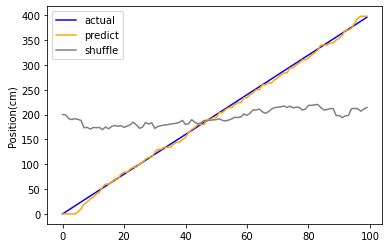

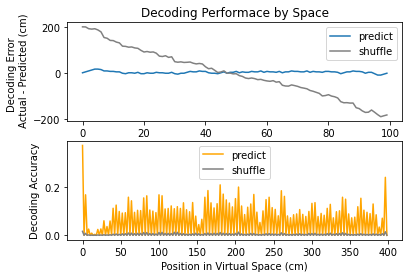

In [48]:
# # perfect events
# time_Bins = 100
# dtime = 0.001
# cell_activity = np.zeros((cell_num, time_Bins))
# position = np.arange(0, track_len, 4)
# for i in range(cell_num):
#     for t in range(time_Bins):
#         if pc_list[i][0] - pc_list[i][1] / 2 < position[t] < pc_list[i][0] + pc_list[i][1]:
#             cell_activity[i][t] = 1 / dtime * gaussian(pc_list[i][0], pc_list[i][1] / 3, position[t])
# PD = Position_basedDecoder(dtime, track_len, track_sample_len, track_Bins, cell_num, tuning, loc_possi=loc_possi)
# PD.test(cell_activity, position)

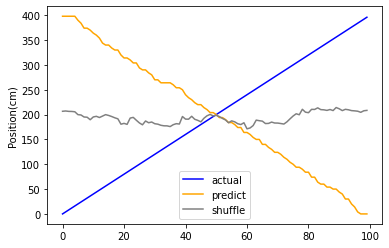

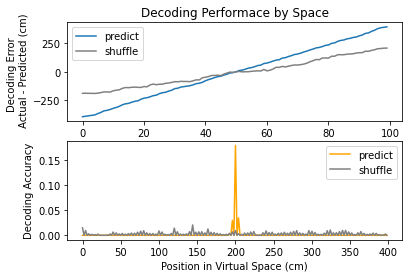

In [49]:
# # perfect reverse events
# rev_cell_activity = np.zeros((cell_num, time_Bins))
# for i in range(cell_num):
#     rev_cell_activity[i] = cell_activity[-i-1]
# PD.test(rev_cell_activity, position)

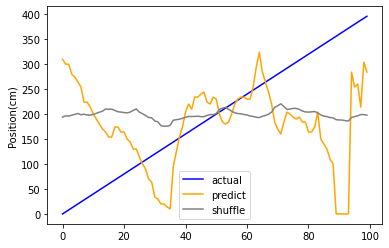

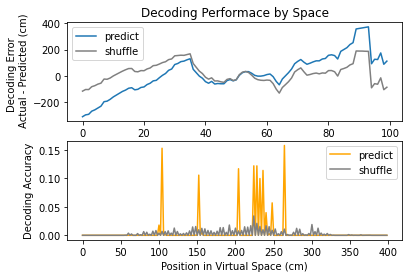

In [50]:
# # random events
# cells = np.arange(0, cell_num)
# np.random.shuffle(cells)
# random_cell_activity = np.zeros((cell_num, time_Bins))
# for i in range(cell_num):
#     random_cell_activity[i] = cell_activity[cells[i]]
# PD.test(random_cell_activity, position)

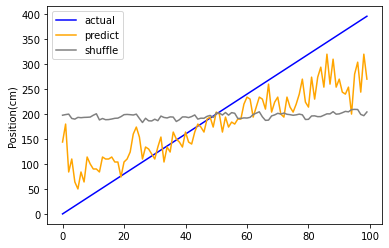

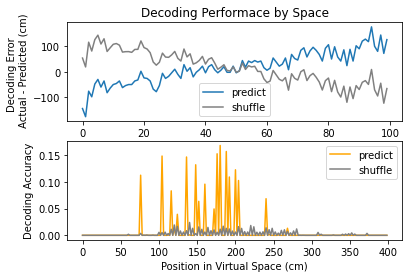

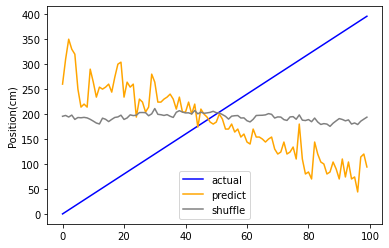

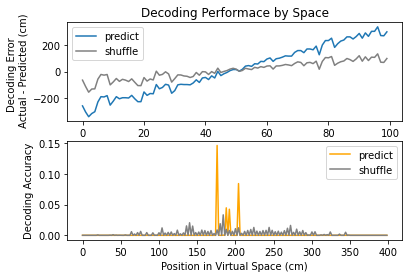

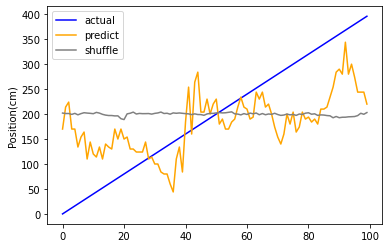

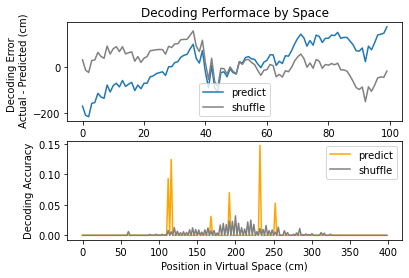

In [51]:
# random_cells = np.arange(0, cell_num)
# np.random.shuffle(random_cells)
# random_cells = random_cells[0:10]
# for i in random_cells:
#     cell_activity[i] = np.random.random(size=time_Bins) / dtime
#     rev_cell_activity[i] = np.random.random(time_Bins) / dtime
#     random_cell_activity[i] = np.random.random(time_Bins) / dtime
# PD.test(cell_activity, position)
# PD.test(rev_cell_activity, position)
# PD.test(random_cell_activity, position)